In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import matplotlib.colors as colors
import multiprocessing
import warnings

from nanonets.utils import BLUE_COLOR, RED_COLOR, get_net_currents, create_weighted_undirected_graph, display_net_flow_graph, extract_harmonic_features
from nanonets import Simulation
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull, KDTree
from scipy.spatial.distance import pdist
from scipy.stats import gaussian_kde
from tqdm import tqdm
from scipy.optimize import curve_fit

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="seaborn"
)

plt.style.use(["science","bright","grid"])
PATH    = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/freq_manipulation/"
# PATH    = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation/f0_1/"

PATH_R  = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/res_disorder_freq_manipulation/"
# PATH_R  = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/res_disorder_freq_manipulation/"

In [ ]:
def MC_effective_volume(points, M_samples, fixed_radius, global_bounds):
    """
    Calculates the 'Effective Volume' of a high-dimensional point cloud using 
    Monte Carlo integration with a fixed probe radius.

    This function estimates the volume of the union of hyperspheres centered at each 
    data point. It is useful for quantifying the "reachable state space" or 
    "expressivity" of a reservoir computer in harmonic space.

    Parameters:
    -----------
    points : np.ndarray
        Array of shape (N_points, D_dimensions) containing the coordinates of the 
        reachable states (e.g., normalized harmonic phasors).
    M_samples : int
        Number of Monte Carlo samples to generate. Higher values reduce variance 
        but increase computation time. Suggest > 100,000 for D > 3.
    fixed_radius : float
        The radius of the hypersphere surrounding each point. This defines the 
        "resolution" of the volume.
        - Small radius: Measures point density (Volume ~ N * V_sphere).
        - Large radius: Approaches the Convex Hull volume (ignoring holes).
    global_bounds : tuple of (np.ndarray, np.ndarray)
        A tuple (min_bounds, max_bounds) defining the hyper-rectangle to sample within.
        Ensure these bounds fully enclose the 'points' + 'fixed_radius' to avoid clipping.

    Returns:
    --------
    float
        The estimated effective volume occupied by the point cloud.
    """
    
    # 1. Setup Bounding Box Dimensions
    min_bounds, max_bounds = global_bounds
    
    # Calculate the side lengths of the sampling box
    # (Vector of length D, allowing for non-cubic bounds)
    side_lengths = max_bounds - min_bounds
    
    # Calculate total volume of the sampling box (V_0)
    # This serves as the reference volume for the Monte Carlo integration
    v0_volume = np.prod(side_lengths)

    # 2. Generate Random Samples (Monte Carlo)
    # Create random points uniformly distributed within the [0, 1] hypercube
    raw_samples = np.random.rand(M_samples, points.shape[1])
    
    # Scale and shift samples to fit inside the 'global_bounds' box
    samples = raw_samples * side_lengths + min_bounds

    # 3. Neighbor Search (The "Hit" Test)
    # Build a KDTree for efficient nearest-neighbor lookup
    tree = KDTree(points)
    
    # Query the tree: Find the distance to the single nearest neighbor for each sample
    # k=1 returns only the nearest neighbor distance
    d_to_nn, _ = tree.query(samples, k=1)
    
    # 4. Count Hits
    # A sample is a "hit" if it falls within 'fixed_radius' of ANY point in the set
    hits = np.sum(d_to_nn <= fixed_radius)

    # 5. Calculate Effective Volume
    # V_eff = (Fraction of Hits) * (Total Box Volume)
    p_hit_rate = hits / M_samples
    v_mc_eff = p_hit_rate * v0_volume

    return v_mc_eff

def get_frequency_spectrum(signal, dt):
    """
    Computes the calibrated one-sided amplitude spectrum.
    
    Parameters:
    - signal: 1D numpy array (time domain)
    - dt: Time step in seconds
    
    Returns:
    - freqs: Array of frequencies [Hz]
    - amplitudes: Array of physical amplitudes [A] (or whatever unit signal is in)
    """
    N_samples = len(signal)
    
    # 1. Apply Window (Consistent with your previous analysis)
    window = np.blackman(N_samples)
    y_val = signal - np.mean(signal)
    y_windowed = y_val * window
    
    # Window Coherent Gain Correction
    w_gain = np.sum(window) / N_samples
    
    # 2. Compute FFT
    fft_vals = np.fft.rfft(y_windowed)
    freqs = np.fft.rfftfreq(N_samples, dt)
    
    # 3. Normalize Magnitude
    # Scale for one-sided (*2), normalize by N, correct for window loss
    amplitudes = (np.abs(fft_vals) * 2 / N_samples) / w_gain
    
    return freqs, amplitudes

def compute_spectral_centroid(amplitudes, harmonic_orders, exclude_fundamental=True):
    """
    Calculates the Spectral Centroid (Center of Mass of the Harmonic Spectrum).
    
    Formula: C = Sum(n * A_n^2) / Sum(A_n^2)
    (Weighted by Power, consistent with energy distribution)
    
    Parameters:
    - amplitudes: Array of magnitudes [A_1, A_3, A_5...]
    - harmonic_orders: Array of harmonic indices [1, 3, 5...]
    - exclude_fundamental: If True, calculates the centroid of the DISTORTION only (n > 1).
                           If False, includes the fundamental frequency.
    
    Returns:
    - centroid: The weighted average harmonic order (e.g., 3.5 means energy is between n=3 and n=5).
    """
    # Ensure inputs are numpy arrays
    amps = np.asarray(amplitudes)
    ords = np.asarray(harmonic_orders)
    
    # 1. Filter: Decide whether to include n=1
    if exclude_fundamental:
        # Only keep harmonics where n > 1
        mask = ords > 1
        valid_amps = amps[mask]
        valid_ords = ords[mask]
    else:
        valid_amps = amps
        valid_ords = ords
        
    # 2. Calculate Power (Square of Amplitude)
    power = valid_amps**2
    total_power = np.sum(power)
    
    # 3. Safety Check for Zero Distortion
    if total_power < 1e-20:
        return np.nan # No harmonic energy exists
        
    # 4. Calculate Centroid
    # Sum(n * Power) / Sum(Power)
    centroid = np.sum(valid_ords * power) / total_power
    
    return centroid

def compute_thd(amplitudes):
    """
    Calculates Total Harmonic Distortion (THD).
    Input: Array of amplitudes [A_fund, A_harm1, A_harm2, ...]
    """
    if len(amplitudes) < 2 or amplitudes[0] == 0:
        return 0.0
        
    power_fund = amplitudes[0]**2
    power_harm = np.sum(amplitudes[1:]**2)
    
    return np.sqrt(power_harm) / np.sqrt(power_fund)

def data_abundance(y):
    y   = np.asarray(y)
    x   = np.sort(y)
    p_x = 1. * np.arange(len(x)) / float(len(x) - 1)
    ab  = 100 - 100*p_x
    return x, ab

## Paramter and Input Time Series

In [ ]:
N_PARTICLES     = 9
N_PERIODS       = 100
N_SAMPLES       = 608
SAMPLE_P_PERIOD = 40
N_EQ_PERIODS    = 80
index_vals      = [3,4,12,15,20,30]
f0_vals         = [1.0,5.0,18.0,28.0]
idx_g           = [12,3,4]
f0_g            = [18.0,28.0,1.0]
lab_g           = ['Min $\\mathcal{G}$', 'Mid $\\mathcal{G}$', 'Max $\\mathcal{G}$']
idx_b           = [15,30,20]
f0_b            = [5.0,28.0,28.0]
lab_b           = ['Min $\\beta$','Mid $\\beta$','Max $\\beta$']

### from bagheera

In [ ]:
data = []
for i in range(N_SAMPLES):
    try:
        data.append(pd.read_csv(f"{PATH}Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne=8_{i}.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True))
    except:
        pass

data_new    = [df['Observable'].values*1e-6 for df in data]
error_new   = [df['Error'].values*1e-6 for df in data]


data_dis_1600   = {}
data_dis_100    = {}
for n in index_vals:
    data_dis_1600[n] = {}
    data_dis_100[n] = {}
    for f0 in f0_vals:
        data_dis_1600[n][f0] = {}
        data_dis_100[n][f0] = {}
        for i in range(N_SAMPLES):
            try:
                data_dis_1600[n][f0][i] = pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_1600.0_{n}_{f0:.3f}.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)
                data_dis_100[n][f0][i] = pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_100.0_{n}_{f0:.3f}.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)
            except:
                pass
    

data_dis_1600_new = {}
data_dis_100_new = {}
error_dis_1600_new = {}
error_dis_100_new = {}
for n in index_vals:
    data_dis_1600_new[n] = {}
    data_dis_100_new[n] = {}
    error_dis_1600_new[n] = {}
    error_dis_100_new[n] = {}
    for f0 in f0_vals:
        data_dis_1600_new[n][f0] = [data_dis_1600[n][f0][i]['Observable'].values*1e-6 for i in data_dis_1600[n][f0].keys()]
        data_dis_100_new[n][f0] = [data_dis_100[n][f0][i]['Observable'].values*1e-6 for i in data_dis_100[n][f0].keys()]
        error_dis_1600_new[n][f0] = [data_dis_1600[n][f0][i]['Error'].values*1e-6 for i in data_dis_1600[n][f0].keys()]
        error_dis_100_new[n][f0] = [data_dis_100[n][f0][i]['Error'].values*1e-6 for i in data_dis_100[n][f0].keys()]

In [77]:
# --- 1. Configuration ---
M_samples       = 100_000 
dim             = 5
n_vals          = np.arange(1, dim + 1, 1)
n_bootstraps    = 10   # Number of resamplings per network/frequency combo
d_factors       = np.logspace(0, 1.5, 21) # Reduced points for speed, covers the saturation

# Indices (Assuming idx_g and idx_b exist in your workspace)
indices_to_run = list(set(idx_g + idx_b))

# --- 2. Data Extraction ---
print("Extracting features (Reference)...")
hh_vectors_ref = np.array([extract_harmonic_features(data_new[i], n_vals, mode='complex', pad_len=4096, interpolate=True) 
                           for i in range(N_SAMPLES)])
# Normalize and Drop H1
hh_vectors_ref = hh_vectors_ref / hh_vectors_ref[:, 0, np.newaxis]
hh_vectors_ref = hh_vectors_ref[:, 2:]

print("Extracting features (Disordered)...")
hh_vectors_dis = {}
for n in indices_to_run:
    hh_vectors_dis[n] = {}
    for f0 in f0_vals:
        raw_vecs = np.array([extract_harmonic_features(data_dis_1600_new[n][f0][i], n_vals, mode='complex', pad_len=4096, interpolate=True) 
                             for i in range(len(data_dis_1600_new[n][f0]))])
        norm_vecs = raw_vecs / raw_vecs[:, 0, np.newaxis]
        hh_vectors_dis[n][f0] = norm_vecs[:, 2:]

# --- 3. Compute Global Ruler ---
print("Computing global ruler...")
dis_stack = np.vstack([np.vstack(list(hh_vectors_dis[n].values())) for n in indices_to_run])
# all_data  = np.vstack([dis_stack, hh_vectors_ref])
all_data  = hh_vectors_ref.copy()

if len(all_data) > 10_000:
    idx_sub = np.random.choice(len(all_data), 10_000, replace=False)
    dist_subset = all_data[idx_sub]
else:
    dist_subset = all_data

base_radius_unit = np.median(pdist(dist_subset))
print(f"Base Radius Unit: {base_radius_unit:.4f}")

# --- 4. Parallel Worker Function (Bootstrapped) ---
def worker_bootstrap_disordered(args):
    """
    Args: (n_id, local_data_dict, f0_list, d_factors, ruler, n_boot, M, seeds)
    Returns: (n_id, results_dict) where results_dict[f0] = {'mean': [], 'std': []}
    """
    n_id, local_data, f0_list, d_facs, ruler, n_boot, M, seeds = args
    
    # Store results for all frequencies of this network
    network_results = {}
    
    for f_idx, f0 in enumerate(f0_list):
        points_original = local_data[f0]
        seed = seeds[f_idx] # Unique seed per frequency
        rng = np.random.default_rng(seed)
        
        # Define Fixed Bounds for this specific cloud (Critical for stable volume)
        sys_min = points_original.min(axis=0)
        sys_max = points_original.max(axis=0)
        max_r = ruler
        fixed_bounds = (sys_min - max_r*2.0, sys_max + max_r*2.0)
        
        # Bootstrap Storage: (n_boot, n_radii)
        bootstrap_curves = np.zeros((n_boot, len(d_facs)))
        
        for b in range(n_boot):
            # Resample
            n_pts = len(points_original)
            resample_idx = rng.integers(0, n_pts, n_pts)
            points_resampled = points_original[resample_idx]
            
            # Sweep Radii
            for i, factor in enumerate(d_facs):
                radius = factor * ruler
                v = MC_effective_volume(points_resampled, M, radius, fixed_bounds)
                bootstrap_curves[b, i] = v
        
        # Compute Stats
        network_results[f0] = {
            'mean': np.mean(bootstrap_curves, axis=0),
            'std':  np.std(bootstrap_curves, axis=0)
        }
        
    return n_id, network_results

# --- 5. Execution ---
if __name__ == "__main__":
    tasks = []
    # Create one task per Network ID (handling all its frequencies inside)
    for n in indices_to_run:
        # Generate enough seeds for all frequencies
        seeds = np.random.randint(0, 10**9, len(f0_vals))
        
        task_args = (
            n, 
            hh_vectors_dis[n], 
            f0_vals, 
            d_factors, 
            base_radius_unit,
            n_bootstraps,
            M_samples,
            seeds
        )
        tasks.append(task_args)
    
    print(f"Starting pool for {len(tasks)} networks...")
    
    with multiprocessing.Pool(processes=max(1, multiprocessing.cpu_count() - 1)) as pool:
        results_list = pool.map(worker_bootstrap_disordered, tasks)
    
    V_eff_dis_dic = {n: res for n, res in results_list}
    print("Parallel processing complete.")

    # --- 6. Reference Calculation (Bootstrapped) ---
    print("Calculating Reference (9x9) with Bootstrap...")
    sys_min = hh_vectors_ref.min(axis=0)
    sys_max = hh_vectors_ref.max(axis=0)
    max_r = base_radius_unit
    ref_bounds = (sys_min - max_r*2.0, sys_max + max_r*2.0)
    
    ref_boot_curves = np.zeros((n_bootstraps, len(d_factors)))
    rng = np.random.default_rng(42)
    
    for b in range(n_bootstraps):
        idx = rng.integers(0, len(hh_vectors_ref), len(hh_vectors_ref))
        pts_res = hh_vectors_ref[idx]
        for i, factor in enumerate(d_factors):
            rad = factor * base_radius_unit
            ref_boot_curves[b, i] = MC_effective_volume(pts_res, M_samples, rad, ref_bounds)
            
    V_eff_ref_stats = {
        'mean': np.mean(ref_boot_curves, axis=0),
        'std': np.std(ref_boot_curves, axis=0)
    }

Extracting features (Reference)...
Extracting features (Disordered)...
Computing global ruler...
Base Radius Unit: 0.1643
Starting pool for 6 networks...
Parallel processing complete.
Calculating Reference (9x9) with Bootstrap...


In [78]:
# --- 1. Configuration ---
M_samples       = 100_000 
dim             = 5
n_vals          = np.arange(1, dim + 1, 1)
n_bootstraps    = 10                        # Number of resamplings per network/frequency combo
d_factors       = np.logspace(0, 1.5, 21)   # Reduced points for speed, covers the saturation

# Indices (Assuming idx_g and idx_b exist in your workspace)
indices_to_run = list(set(idx_g + idx_b))

# --- 2. Data Extraction ---
print("Extracting features (Reference)...")
hh_vectors_ref = np.array([extract_harmonic_features(data_new[i], n_vals, mode='complex', pad_len=4096, interpolate=True) 
                           for i in range(N_SAMPLES)])
# Normalize and Drop H1
hh_vectors_ref = hh_vectors_ref / hh_vectors_ref[:, 0, np.newaxis]
hh_vectors_ref = hh_vectors_ref[:, 2:]

print("Extracting features (Disordered)...")
hh_vectors_dis = {}
for n in indices_to_run:
    hh_vectors_dis[n] = {}
    for f0 in f0_vals:
        raw_vecs = np.array([extract_harmonic_features(data_dis_100_new[n][f0][i], n_vals, mode='complex', pad_len=4096, interpolate=True) 
                             for i in range(len(data_dis_100_new[n][f0]))])
        norm_vecs = raw_vecs / raw_vecs[:, 0, np.newaxis]
        hh_vectors_dis[n][f0] = norm_vecs[:, 2:]

# --- 3. Compute Global Ruler ---
print("Computing global ruler...")
dis_stack = np.vstack([np.vstack(list(hh_vectors_dis[n].values())) for n in indices_to_run])
# all_data  = np.vstack([dis_stack, hh_vectors_ref])
all_data  = hh_vectors_ref.copy()

if len(all_data) > 10_000:
    idx_sub = np.random.choice(len(all_data), 10_000, replace=False)
    dist_subset = all_data[idx_sub]
else:
    dist_subset = all_data

base_radius_unit = np.median(pdist(dist_subset))
print(f"Base Radius Unit: {base_radius_unit:.4f}")

# --- 4. Parallel Worker Function (Bootstrapped) ---
def worker_bootstrap_disordered(args):
    """
    Args: (n_id, local_data_dict, f0_list, d_factors, ruler, n_boot, M, seeds)
    Returns: (n_id, results_dict) where results_dict[f0] = {'mean': [], 'std': []}
    """
    n_id, local_data, f0_list, d_facs, ruler, n_boot, M, seeds = args
    
    # Store results for all frequencies of this network
    network_results = {}
    
    for f_idx, f0 in enumerate(f0_list):
        points_original = local_data[f0]
        seed = seeds[f_idx] # Unique seed per frequency
        rng = np.random.default_rng(seed)
        
        # Define Fixed Bounds for this specific cloud (Critical for stable volume)
        sys_min = points_original.min(axis=0)
        sys_max = points_original.max(axis=0)
        max_r = ruler
        fixed_bounds = (sys_min - max_r*2.0, sys_max + max_r*2.0)
        
        # Bootstrap Storage: (n_boot, n_radii)
        bootstrap_curves = np.zeros((n_boot, len(d_facs)))
        
        for b in range(n_boot):
            # Resample
            n_pts = len(points_original)
            resample_idx = rng.integers(0, n_pts, n_pts)
            points_resampled = points_original[resample_idx]
            
            # Sweep Radii
            for i, factor in enumerate(d_facs):
                radius = factor * ruler
                v = MC_effective_volume(points_resampled, M, radius, fixed_bounds)
                bootstrap_curves[b, i] = v
        
        # Compute Stats
        network_results[f0] = {
            'mean': np.mean(bootstrap_curves, axis=0),
            'std':  np.std(bootstrap_curves, axis=0)
        }
        
    return n_id, network_results

# --- 5. Execution ---
if __name__ == "__main__":
    tasks = []
    # Create one task per Network ID (handling all its frequencies inside)
    for n in indices_to_run:
        # Generate enough seeds for all frequencies
        seeds = np.random.randint(0, 10**9, len(f0_vals))
        
        task_args = (
            n, 
            hh_vectors_dis[n], 
            f0_vals, 
            d_factors, 
            base_radius_unit,
            n_bootstraps,
            M_samples,
            seeds
        )
        tasks.append(task_args)
    
    print(f"Starting pool for {len(tasks)} networks...")
    
    with multiprocessing.Pool(processes=max(1, multiprocessing.cpu_count() - 1)) as pool:
        results_list = pool.map(worker_bootstrap_disordered, tasks)
    
    V_eff_dis_dic_100 = {n: res for n, res in results_list}
    print("Parallel processing complete.")

    # --- 6. Reference Calculation (Bootstrapped) ---
    print("Calculating Reference (9x9) with Bootstrap...")
    sys_min = hh_vectors_ref.min(axis=0)
    sys_max = hh_vectors_ref.max(axis=0)
    max_r = base_radius_unit
    ref_bounds = (sys_min - max_r*2.0, sys_max + max_r*2.0)
    
    ref_boot_curves = np.zeros((n_bootstraps, len(d_factors)))
    rng = np.random.default_rng(42)
    
    for b in range(n_bootstraps):
        idx = rng.integers(0, len(hh_vectors_ref), len(hh_vectors_ref))
        pts_res = hh_vectors_ref[idx]
        for i, factor in enumerate(d_factors):
            rad = factor * base_radius_unit
            ref_boot_curves[b, i] = MC_effective_volume(pts_res, M_samples, rad, ref_bounds)
            
    V_eff_ref_stats_100 = {
        'mean': np.mean(ref_boot_curves, axis=0),
        'std': np.std(ref_boot_curves, axis=0)
    }

Extracting features (Reference)...
Extracting features (Disordered)...
Computing global ruler...
Base Radius Unit: 0.1643
Starting pool for 6 networks...
Parallel processing complete.
Calculating Reference (9x9) with Bootstrap...


In [233]:
from scipy.interpolate import UnivariateSpline
def get_inflection_point_logx(x, y, s=0, n_fine=3000):
    """
    Returns (x_inflect, y_inflect) for a sigmoid-like curve,
    using a spline in log10(x) space.
    
    Parameters
    ----------
    x : array-like
        Must be positive and monotonic
    y : array-like
    s : float
        Smoothing factor for spline (0 = interpolation)
    n_fine : int
        Resolution of fine grid for zero-crossing detection
    """
    x = np.asarray(x)
    y = np.asarray(y)

    if np.any(x <= 0):
        raise ValueError("x must be strictly positive for log-scaling.")

    x_log = np.log10(x)

    spline = UnivariateSpline(x_log, y, s=s, k=3)

    x_log_fine = np.linspace(x_log.min(), x_log.max(), n_fine)
    d2y = spline.derivative(n=2)(x_log_fine)

    # Find zero crossing of second derivative
    sign_change = np.where(np.diff(np.sign(d2y)) != 0)[0]
    if len(sign_change) == 0:
        raise ValueError("No inflection point found.")

    i = sign_change[0]

    # Linear interpolation for root
    x0, x1 = x_log_fine[i], x_log_fine[i + 1]
    y0, y1 = d2y[i], d2y[i + 1]

    x_log_inflect = x0 - y0 * (x1 - x0) / (y1 - y0)
    x_inflect = 10 ** x_log_inflect
    y_inflect = spline(x_log_inflect)

    return x_inflect, y_inflect

def inflection_point_mc(x, y, y_err, n_mc=1000, **kwargs):
    """
    Monte Carlo uncertainty propagation for inflection point.
    
    Returns:
        x_mean, x_std, y_mean, y_std
    """
    x_vals = []
    y_vals = []

    for _ in range(n_mc):
        y_sample = np.random.normal(y, y_err)

        try:
            x_i, y_i = get_inflection_point_logx(x, y_sample, **kwargs)
            x_vals.append(x_i)
            y_vals.append(y_i)
        except ValueError:
            continue

    x_vals = np.array(x_vals)
    y_vals = np.array(y_vals)

    return (
        np.mean(x_vals), np.std(x_vals),
        np.mean(y_vals), np.std(y_vals)
    )

def saturation_point(x, y, frac=0.95):
    """
    Returns (x_sat, y_sat) where y first reaches frac * max(y).
    """
    y_max = np.max(y)
    target = frac * y_max

    idx = np.where(y >= target)[0]
    if len(idx) == 0:
        raise ValueError("Saturation not reached in data range.")

    i = idx[0]

    # Linear interpolation for sub-grid accuracy
    if i == 0:
        return x[0], y[0]

    x0, x1 = x[i - 1], x[i]
    y0, y1 = y[i - 1], y[i]

    x_sat = x0 + (target - y0) * (x1 - x0) / (y1 - y0)
    y_sat = target

    return x_sat, y_sat

def saturation_point_mc(x, y, y_err, frac=0.95, n_mc=2000):
    """
    Monte Carlo uncertainty propagation for saturation point.
    
    Returns:
        x_mean, x_std, y_mean, y_std
    """
    x_vals = []
    y_vals = []

    for _ in range(n_mc):
        y_sample = np.random.normal(y, y_err)

        try:
            x_i, y_i = saturation_point(x, y_sample, frac=frac)
            x_vals.append(x_i)
            y_vals.append(y_i)
        except ValueError:
            continue

    x_vals = np.asarray(x_vals)
    y_vals = np.asarray(y_vals)

    return (
        np.mean(x_vals), np.std(x_vals),
        np.mean(y_vals), np.std(y_vals)
    )


In [260]:
V_eff_dis_df_mean = pd.DataFrame(np.array(
    [[saturation_point_mc(d_factors, V_eff_dis_dic_100[n][f0]['mean'], V_eff_dis_dic_100[n][f0]['std']/1.96, frac=0.9, n_mc=2000)[2] for f0,n in zip(f0_g+f0_b,idx_g+idx_b)],
     [saturation_point_mc(d_factors, V_eff_dis_dic[n][f0]['mean'], V_eff_dis_dic[n][f0]['std'], frac=0.9, n_mc=2000)[2] for f0,n in zip(f0_g+f0_b,idx_g+idx_b)]]).T,
     index=lab_g+lab_b, columns=['$\\kappa = 4$','$\\kappa = 64$'])
V_eff_dis_df_std = pd.DataFrame(np.array(
    [[saturation_point_mc(d_factors, V_eff_dis_dic_100[n][f0]['mean'], V_eff_dis_dic_100[n][f0]['std']/1.96, frac=0.9, n_mc=2000)[3] for f0,n in zip(f0_g+f0_b,idx_g+idx_b)],
     [saturation_point_mc(d_factors, V_eff_dis_dic[n][f0]['mean'], V_eff_dis_dic[n][f0]['std'], frac=0.9, n_mc=2000)[3] for f0,n in zip(f0_g+f0_b,idx_g+idx_b)]]).T,
     index=lab_g+lab_b, columns=['$\\kappa = 4$','$\\kappa = 64$'])
V_eff_ref_vals = saturation_point_mc(d_factors, V_eff_ref_stats['mean'], V_eff_ref_stats['std']/1.96, frac=0.9, n_mc=2000)

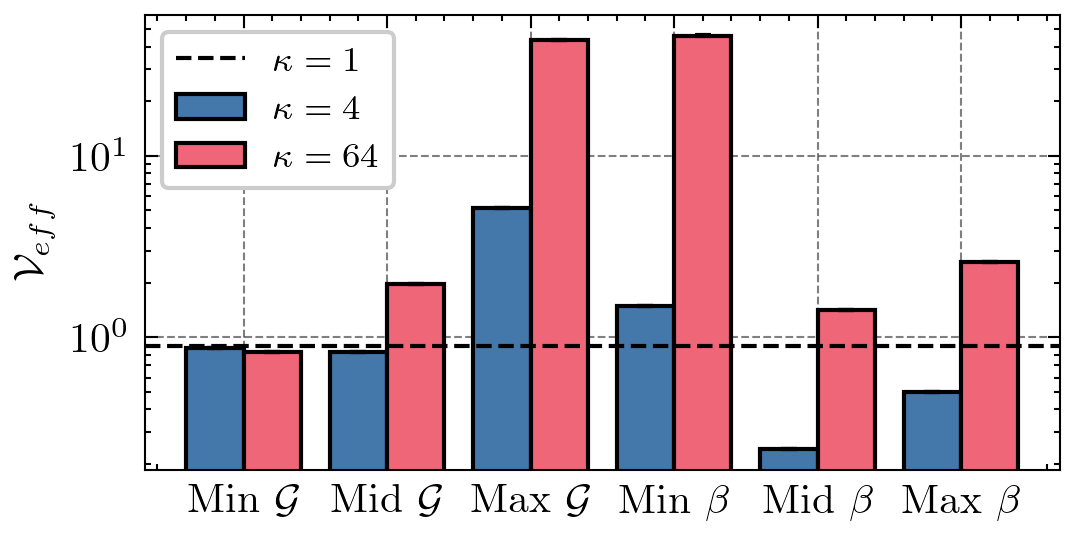

In [265]:
fig, ax = plt.subplots(dpi=300)
fig.set_figwidth(fig.get_figwidth()*1.5)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
_       = plt.axhline(y=V_eff_ref_vals[2], color='black', ls='dashed', label="$\\kappa = 1$")
_       = ax.bar(x=lab_g+lab_b, height=V_eff_dis_df_mean.iloc[:,0], yerr=V_eff_dis_df_std.iloc[:,0]*1.96,
                 label='$\\kappa = 4$', align='edge', width=-0.4, edgecolor='black', capsize=2)
_       = ax.bar(x=lab_g+lab_b, height=V_eff_dis_df_mean.iloc[:,1], yerr=V_eff_dis_df_std.iloc[:,1]*1.96,
                 label='$\\kappa = 64$', align='edge', width=0.4, edgecolor='black', capsize=2)
_       = ax.set_yscale('log')
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")
_       = ax.legend(fontsize='small', loc='upper left')

fig.savefig(f"plots/png/V_eff_disorder_at_best_f0.png", transparent=False)
fig.savefig(f"plots/pdf/V_eff_disorder_at_best_f0.pdf", transparent=False)
fig.savefig(f"plots/svg/V_eff_disorder_at_best_f0.svg", transparent=True)

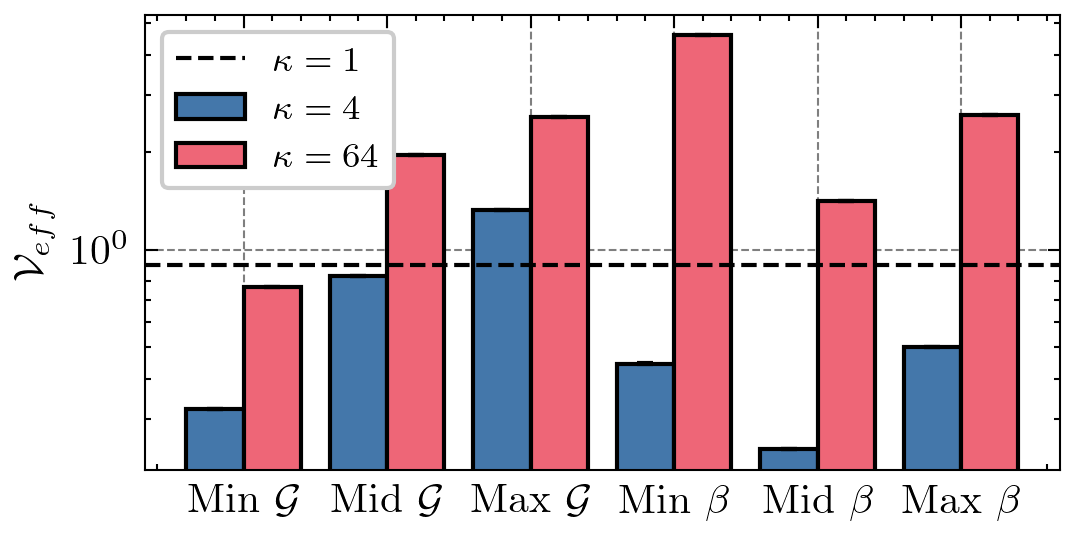

In [269]:
f0                = 28.0
V_eff_dis_df_mean = pd.DataFrame(np.array(
    [[saturation_point_mc(d_factors, V_eff_dis_dic_100[n][f0]['mean'], V_eff_dis_dic_100[n][f0]['std'], frac=0.9, n_mc=2000)[2] for n in idx_g+idx_b],
     [saturation_point_mc(d_factors, V_eff_dis_dic[n][f0]['mean'], V_eff_dis_dic[n][f0]['std'], frac=0.9, n_mc=2000)[2] for n in idx_g+idx_b]]).T,
     index=lab_g+lab_b, columns=['$\\kappa = 4$','$\\kappa = 64$'])
V_eff_dis_df_std = pd.DataFrame(np.array(
    [[saturation_point_mc(d_factors, V_eff_dis_dic_100[n][f0]['mean'], V_eff_dis_dic_100[n][f0]['std'], frac=0.9, n_mc=2000)[3] for n in idx_g+idx_b],
     [saturation_point_mc(d_factors, V_eff_dis_dic[n][f0]['mean'], V_eff_dis_dic[n][f0]['std'], frac=0.9, n_mc=2000)[3] for n in idx_g+idx_b]]).T,
     index=lab_g+lab_b, columns=['$\\kappa = 4$','$\\kappa = 64$'])
V_eff_ref_vals = saturation_point_mc(d_factors, V_eff_ref_stats['mean'], V_eff_ref_stats['std'], frac=0.9, n_mc=2000)

fig, ax = plt.subplots(dpi=300)
fig.set_figwidth(fig.get_figwidth()*1.5)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
_       = plt.axhline(y=V_eff_ref_vals[2], color='black', ls='dashed', label="$\\kappa = 1$")
_       = ax.bar(x=lab_g+lab_b, height=V_eff_dis_df_mean.iloc[:,0], yerr=V_eff_dis_df_std.iloc[:,0],
                 label='$\\kappa = 4$', align='edge', width=-0.4, edgecolor='black', capsize=2)
_       = ax.bar(x=lab_g+lab_b, height=V_eff_dis_df_mean.iloc[:,1], yerr=V_eff_dis_df_std.iloc[:,1],
                 label='$\\kappa = 64$', align='edge', width=0.4, edgecolor='black', capsize=2)
_       = ax.set_yscale('log')
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")
_       = ax.legend(fontsize='small', loc='upper left')

fig.savefig(f"plots/png/V_eff_disorder_at_spec_{f0}.png", transparent=False)
fig.savefig(f"plots/pdf/V_eff_disorder_at_spec_{f0}.pdf", transparent=False)
fig.savefig(f"plots/svg/V_eff_disorder_at_spec_{f0}.svg", transparent=True)

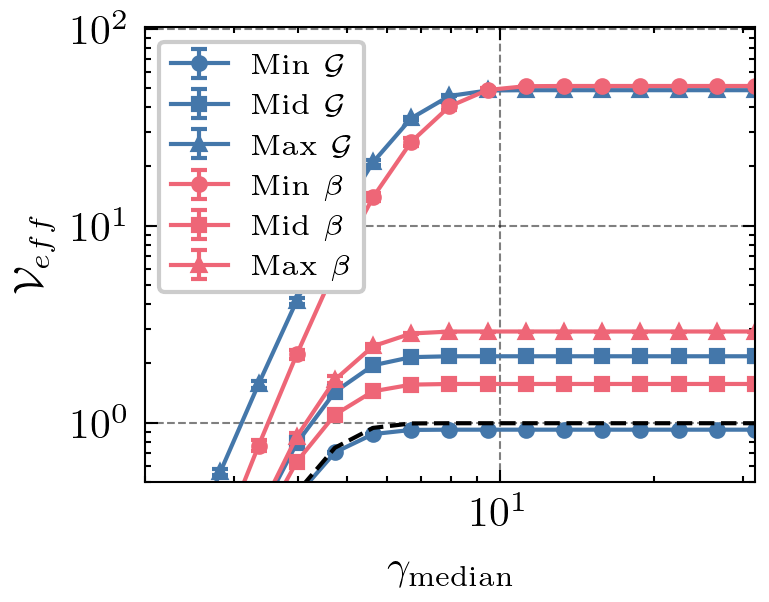

In [270]:
mss     = ['o','s','^']
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i in range(3):
    _ = ax.errorbar(d_factors, V_eff_dis_dic[idx_g[i]][f0_g[i]]['mean'], V_eff_dis_dic[idx_g[i]][f0_g[i]]['std'],
                    label=lab_g[i], color=BLUE_COLOR, marker=mss[i], capsize=2, ms=3)
for i in range(3):
    _ = ax.errorbar(d_factors, V_eff_dis_dic[idx_b[i]][f0_b[i]]['mean'], V_eff_dis_dic[idx_b[i]][f0_b[i]]['std'],
                    label=lab_b[i], color=RED_COLOR, marker=mss[i], capsize=2, ms=3)
_   = ax.errorbar(d_factors, V_eff_ref_stats['mean'], V_eff_ref_stats['std'], c='black', ls='dashed')
_   = ax.set_xlim(d_factors[0], d_factors[-1])
_   = ax.set_xlabel("$\gamma_\\textrm{median}$")
_   = ax.set_xscale('log')
_   = ax.set_ylabel("$\mathcal{V}_{eff}$")
_   = ax.legend(fontsize='x-small', loc='upper left', ncol=1)
_   = ax.set_yscale('log')
_   = ax.set_ylim(5e-1)
_   = ax.set_xlim(2)

fig.savefig(f"plots/png/V_eff_disorder_vs_gamma_1600.png", transparent=False)
fig.savefig(f"plots/pdf/V_eff_disorder_vs_gamma_1600.pdf", transparent=False)
fig.savefig(f"plots/svg/V_eff_disorder_vs_gamma_1600.svg", transparent=True)

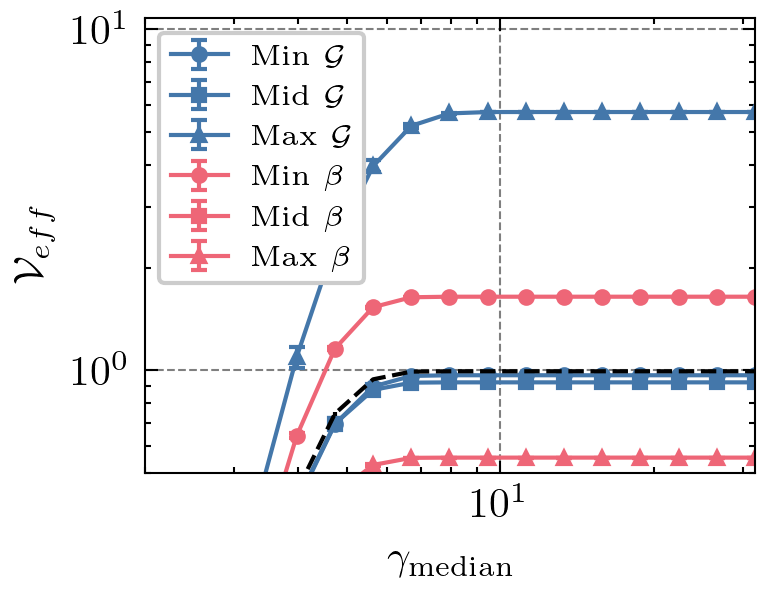

In [271]:
mss     = ['o','s','^']
fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i in range(3):
    _ = ax.errorbar(d_factors, V_eff_dis_dic_100[idx_g[i]][f0_g[i]]['mean'], V_eff_dis_dic_100[idx_g[i]][f0_g[i]]['std'],
                    label=lab_g[i], color=BLUE_COLOR, marker=mss[i], capsize=2, ms=3)
for i in range(3):
    _ = ax.errorbar(d_factors, V_eff_dis_dic_100[idx_b[i]][f0_b[i]]['mean'], V_eff_dis_dic_100[idx_b[i]][f0_b[i]]['std'],
                    label=lab_b[i], color=RED_COLOR, marker=mss[i], capsize=2, ms=3)
_   = ax.errorbar(d_factors, V_eff_ref_stats['mean'], V_eff_ref_stats['std'], c='black', ls='dashed')
_   = ax.set_xlim(d_factors[0], d_factors[-1])
_   = ax.set_xlabel("$\gamma_\\textrm{median}$")
_   = ax.set_xscale('log')
_   = ax.set_ylabel("$\mathcal{V}_{eff}$")
_   = ax.legend(fontsize='x-small', loc='upper left', ncol=1)
_   = ax.set_yscale('log')
_   = ax.set_ylim(5e-1)
_   = ax.set_xlim(2)

fig.savefig(f"plots/png/V_eff_disorder_vs_gamma_100.png", transparent=False)
fig.savefig(f"plots/pdf/V_eff_disorder_vs_gamma_100.pdf", transparent=False)
fig.savefig(f"plots/svg/V_eff_disorder_vs_gamma_100.svg", transparent=True)

### Phase

In [275]:
data_dis_1600_new[12][1.0][0]

array([-177.49173211, -175.8054396 , -174.70455579, -173.78727668,
       -168.91720641, -174.3824192 , -169.18468218, -168.91613216,
       -167.26328152, -167.02120104, -165.05845642, -168.72579313,
       -169.05744749, -165.47781604, -169.18242288, -169.99222949,
       -168.58705178, -169.20269349, -170.05326305, -178.35010816,
       -180.12352782, -181.5620874 , -187.02533318, -186.89059502,
       -185.60856737, -186.84133786, -190.32949978, -198.60686283,
       -192.40171528, -195.76458201, -189.569626  , -196.37108336,
       -195.69289561, -187.22008966, -189.53656255, -190.93607799,
       -187.9210731 , -186.87799674, -179.03609279, -181.70098174,
       -179.76653993, -180.37600223, -176.23008533, -172.8750446 ,
       -177.48141399, -173.53023089, -170.17031724, -165.76718107,
       -163.72929888, -170.77491226, -168.88782918, -164.73066438,
       -165.77972334, -170.58524906, -164.5162303 , -173.00200887,
       -177.49807351, -177.88730058, -173.51539507, -173.89829

In [ ]:
# --- Configuration ---
phase_vectors   = {}
amp_vectors     = {}
M_samples       = 100_000 
dim             = 5
n_vals          = np.arange(2, dim + 1, 1)
B               = 5

# Get Phase
for n in idx_g+idx_b:
    phase_vectors[n] = {}
    amp_vectors[n] = {}
    for f0 in f0_vals:
        phase_vectors[n][f0] = []
        amp_vectors[n][f0] = []
        for i in N_SAMPLES:
            arrs = [data_dis_1600_new[n][f0][i] + np.random.normal(0,data_dis_1600_new[n][f0][i]) for _ in range(B)]
            phase_vectors[n][f0][i] = np.array([extract_harmonic_features(data_dis_1600_new[n][f0][i], n_vals, mode='phase', pad_len=4096, interpolate=True) 
                                            for i in range(N_SAMPLES)])
            amp_vectors[n][f0][i] = np.array([extract_harmonic_features(data_dis_1600_new[n][f0][i], n_vals, mode='abs', pad_len=4096, interpolate=True) 
                                            for i in range(N_SAMPLES)])

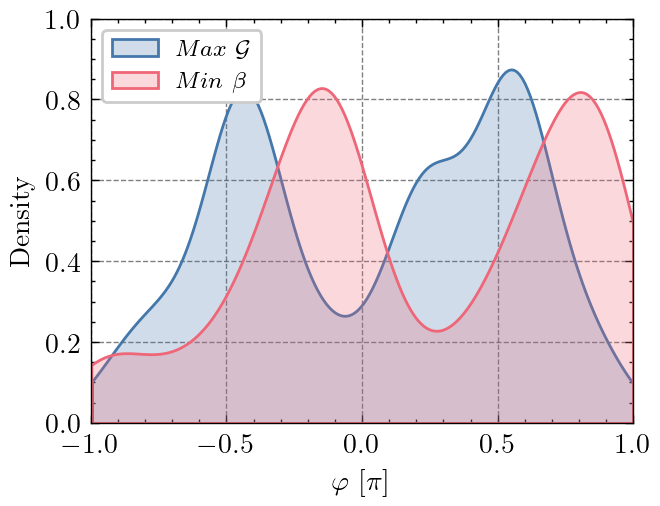

In [274]:
fig, ax = plt.subplots(dpi=200)
df      = pd.DataFrame({'a':phase_vectors[idx_g[-1]][28.0].flatten(),'b':amp_vectors[idx_g[-1]][28.0].flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=BLUE_COLOR, fill=True, label="$Max~\\mathcal{G}$")
df      = pd.DataFrame({'a':phase_vectors[idx_b[0]][28.0].flatten(),'b':amp_vectors[idx_b[0]][28.0].flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=RED_COLOR, fill=True, label="$Min~\\beta$")
_       = ax.set_xlim(-1,1)
_       = ax.set_ylim(0,1)
_       = ax.set_xlabel("$\\varphi~[\mathrm{\pi}]$")
_       = ax.legend(fontsize='small', loc='upper left')

fig.savefig(f"plots/png/phase_of_max_gain_vs_min_beta_.png", transparent=False)
fig.savefig(f"plots/pdf/phase_of_max_gain_vs_min_beta_.pdf", transparent=False)
fig.savefig(f"plots/svg/phase_of_max_gain_vs_min_beta_.svg", transparent=True)

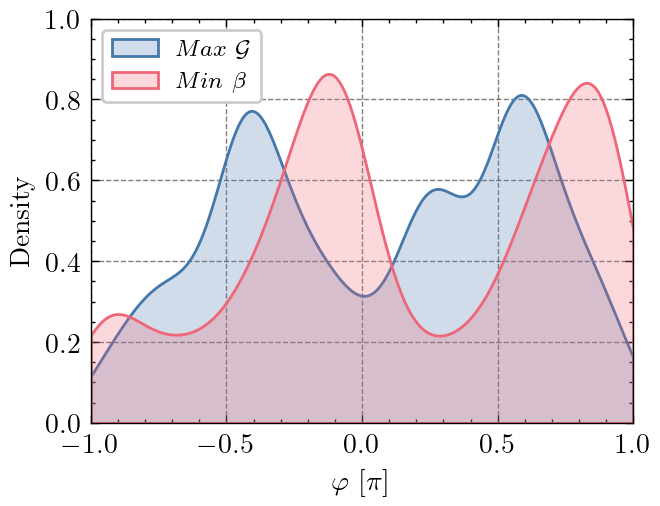

In [288]:
fig, ax = plt.subplots(dpi=200)
df      = pd.DataFrame({'a':np.array([phase_vectors[idx_g[-1]][f0] for f0 in f0_vals]).flatten(),
                        'b':np.array([amp_vectors[idx_g[-1]][f0] for f0 in f0_vals]).flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=BLUE_COLOR, fill=True, label="$Max~\\mathcal{G}$", bw_adjust=1.0)
df      = pd.DataFrame({'a':np.array([phase_vectors[idx_b[0]][f0] for f0 in f0_vals]).flatten(),
                        'b':np.array([amp_vectors[idx_b[0]][f0] for f0 in f0_vals]).flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=RED_COLOR, fill=True, label="$Min~\\beta$", bw_adjust=1.0)
_       = ax.set_xlim(-1,1)
_       = ax.set_ylim(0,1)
_       = ax.set_xlabel("$\\varphi~[\mathrm{\pi}]$")
_       = ax.legend(fontsize='small', loc='upper left')

fig.savefig(f"plots/png/phase_of_max_gain_vs_min_beta_.png", transparent=False)
fig.savefig(f"plots/pdf/phase_of_max_gain_vs_min_beta_.pdf", transparent=False)
fig.savefig(f"plots/svg/phase_of_max_gain_vs_min_beta_.svg", transparent=True)

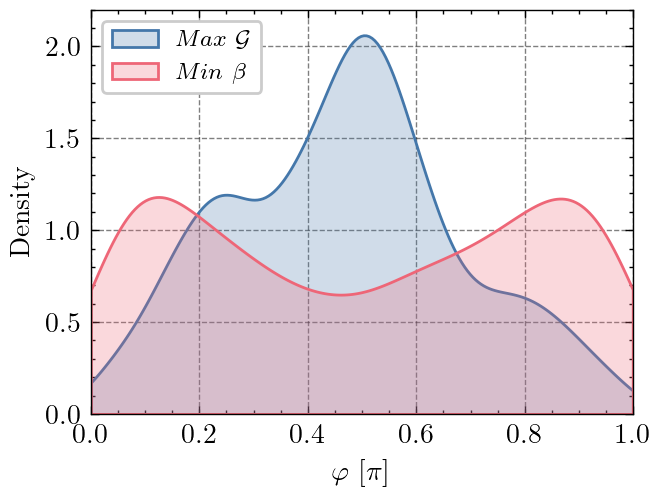

In [292]:
fig, ax = plt.subplots(dpi=200)
# df      = pd.DataFrame({'a':phase_df2["$N_\\textrm{NP} = 81$"].abs(),'b':amp_df2["$N_\\textrm{NP} = 81$"]})
# ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color='grey', fill=True, label='$R_2 = 25~\mathrm{M\Omega}$')
df      = pd.DataFrame({'a':np.abs(phase_vectors[idx_g[-1]][28.0].flatten()),'b':amp_vectors[idx_g[-1]][28.0].flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=BLUE_COLOR, fill=True, label="$Max~\\mathcal{G}$")
df      = pd.DataFrame({'a':np.abs(phase_vectors[idx_b[0]][28.0].flatten()),'b':amp_vectors[idx_b[0]][28.0].flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=RED_COLOR, fill=True, label="$Min~\\beta$")
_       = ax.set_xlim(0,1)
_       = ax.set_ylim(0,2.2)
_       = ax.set_xlabel("$\\varphi~[\mathrm{\pi}]$")
_       = ax.legend(fontsize='small', loc='upper left')

fig.savefig(f"plots/png/abs_phase_of_max_gain_vs_min_beta_.png", transparent=False)
fig.savefig(f"plots/pdf/abs_phase_of_max_gain_vs_min_beta_.pdf", transparent=False)
fig.savefig(f"plots/svg/abs_phase_of_max_gain_vs_min_beta_.svg", transparent=True)

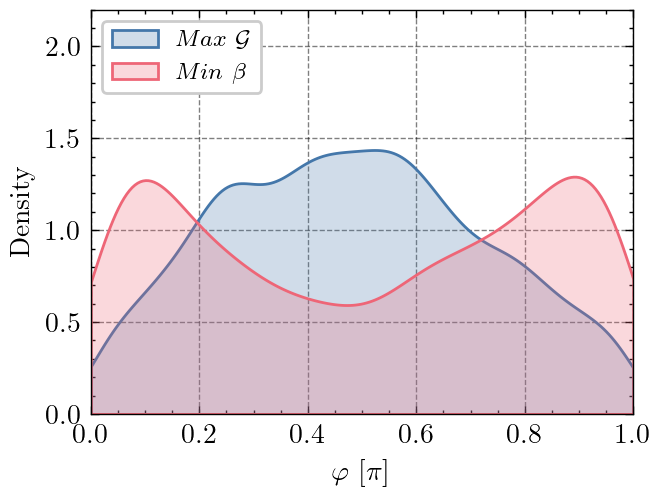

In [291]:
fig, ax = plt.subplots(dpi=200)
df      = pd.DataFrame({'a':np.abs(np.array([phase_vectors[idx_g[-1]][f0] for f0 in f0_vals]).flatten()),
                        'b':np.array([amp_vectors[idx_g[-1]][f0] for f0 in f0_vals]).flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=BLUE_COLOR, fill=True, label="$Max~\\mathcal{G}$", bw_adjust=1.0)
df      = pd.DataFrame({'a':np.abs(np.array([phase_vectors[idx_b[0]][f0] for f0 in f0_vals]).flatten()),
                        'b':np.array([amp_vectors[idx_b[0]][f0] for f0 in f0_vals]).flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=RED_COLOR, fill=True, label="$Min~\\beta$", bw_adjust=1.0)
_       = ax.set_xlim(0,1)
_       = ax.set_ylim(0,2.2)
_       = ax.set_xlabel("$\\varphi~[\mathrm{\pi}]$")
_       = ax.legend(fontsize='small', loc='upper left')

fig.savefig(f"plots/png/abs_phase_of_max_gain_vs_min_beta_.png", transparent=False)
fig.savefig(f"plots/pdf/abs_phase_of_max_gain_vs_min_beta_.pdf", transparent=False)
fig.savefig(f"plots/svg/abs_phase_of_max_gain_vs_min_beta_.svg", transparent=True)

### Nonlinear

In [334]:
hh_vectors_dis  = {}
thd_vals_dis    = {}
centr_vals_dis  = {}
M_samples       = 200000
dim             = 9
d_factors       = np.logspace(-1,1,31)
n_vals          = np.arange(1,dim+1,1)
hh_vectors_ref  = np.array([extract_harmonic_features(data_new[9][i],n_vals,mode='abs',pad_len=8192,interpolate=True) for i in range(N_SAMPLES)])
for n in idx_g+idx_b:
    hh_vectors_dis[n] = {f0 : np.array([extract_harmonic_features(data_dis_1600_new[n][f0][i],n_vals,mode='abs',pad_len=8192,interpolate=True) for i in range(N_SAMPLES)]) for f0 in f0_vals}
for n in idx_g+idx_b:
    thd_vals_dis[n]     = {f0 : [compute_thd(hh_vectors_dis[n][f0][i]) for i in range(N_SAMPLES) if hh_vectors_dis[n][f0][i,0] > noise_floor] for f0 in f0_vals}
    centr_vals_dis[n]   = {f0 : [compute_spectral_centroid(hh_vectors_dis[n][f0][i], n_vals) for i in range(N_SAMPLES) if hh_vectors_dis[n][f0][i,0] > noise_floor] for f0 in f0_vals}

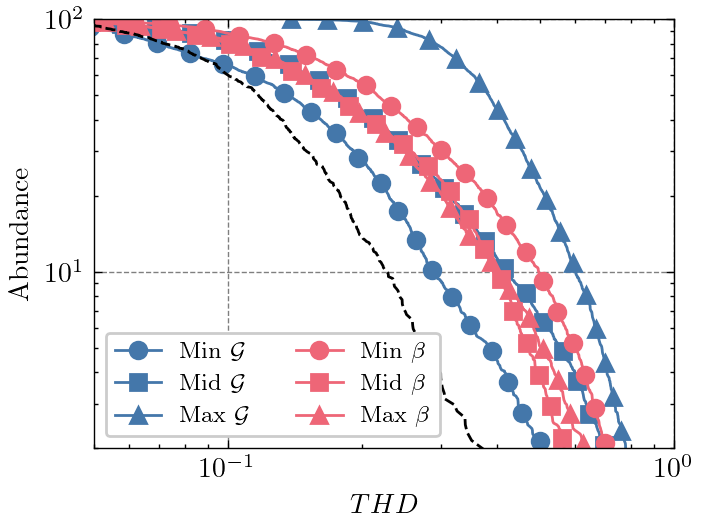

In [346]:
mss = ['o','s','^','v','<','>']
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()

for i, key in enumerate(idx_g):
    x, ab   = data_abundance(np.hstack([thd_vals_dis[key][f0] for f0 in f0_vals]))
    _       = ax.plot(x, ab, label=lab_g[i], marker=mss[i], markevery=0.05, color=BLUE_COLOR)

for i, key in enumerate(idx_b):
    x, ab   = data_abundance(np.hstack([thd_vals_dis[key][f0] for f0 in f0_vals]))
    _       = ax.plot(x, ab, label=lab_b[i], marker=mss[i], markevery=0.05, color=RED_COLOR)

x, ab   = data_abundance(thd_vals[9])
_       = ax.plot(x, ab, markevery=0.05, color='black', ls='--')#, label='$R_2 = 25~\mathrm{M\Omega}$')

_   = ax.legend(fontsize='small', ncol=2, loc='lower left')
_   = ax.set_xlabel('$THD$')
_   = ax.set_ylabel('Abundance')
_   = ax.set_xlim(0.05,1)
_   = ax.set_ylim(2,100)
_   = ax.set_xscale('log')
_   = ax.set_yscale('log')

fig.savefig(f"plots/png/THD_abundance_disorder.png", transparent=False)
fig.savefig(f"plots/pdf/THD_abundance_disorder.pdf", transparent=False)
fig.savefig(f"plots/svg/THD_abundance_disorder.svg", transparent=True)

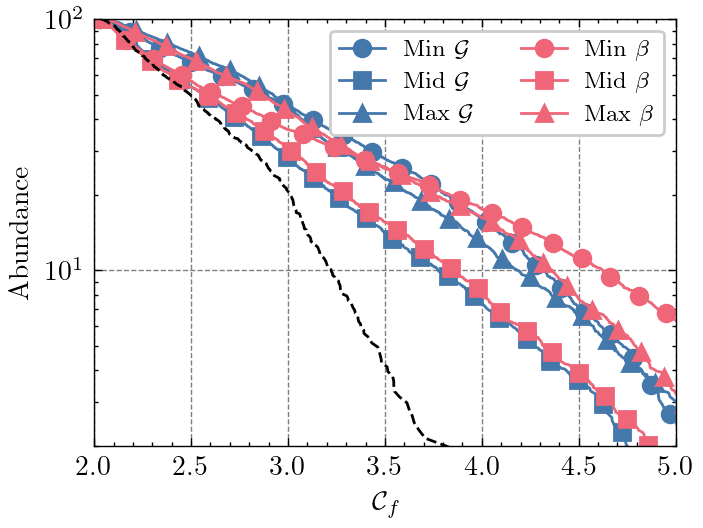

In [347]:
mss = ['o','s','^','v','<','>']
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()

for i, key in enumerate(idx_g):
    x, ab   = data_abundance(np.hstack([centr_vals_dis[key][f0] for f0 in f0_vals]))
    _       = ax.plot(x, ab, label=lab_g[i], marker=mss[i], markevery=0.05, color=BLUE_COLOR)

for i, key in enumerate(idx_b):
    x, ab   = data_abundance(np.hstack([centr_vals_dis[key][f0] for f0 in f0_vals]))
    _       = ax.plot(x, ab, label=lab_b[i], marker=mss[i], markevery=0.05, color=RED_COLOR)

x, ab   = data_abundance(centr_vals[9])
_       = ax.plot(x, ab, markevery=0.05, color='black', ls='--')#, label='$R_2 = 25~\mathrm{M\Omega}$')

_   = ax.legend(fontsize='small', ncol=2, loc='upper right')
_   = ax.set_xlabel('$\mathcal{C}_f$')
_   = ax.set_ylabel('Abundance')
_   = ax.set_xlim(2,5)
_   = ax.set_ylim(2,100)
_   = ax.set_yscale('log')

fig.savefig(f"plots/png/Cf_abundance_disorder.png", transparent=False)
fig.savefig(f"plots/pdf/Cf_abundance_disorder.pdf", transparent=False)
fig.savefig(f"plots/svg/Cf_abundance_disorder.svg", transparent=True)

In [305]:
# mss = ['o','s','^','v','<','>']
# fig = plt.figure(dpi=200, layout='constrained')
# ax  = fig.add_subplot()
# f0  = 28.0

# for i, key in enumerate(idx_g):
#     x, ab   = data_abundance(thd_vals_dis[key][f0])
#     _       = ax.plot(x, ab, label=lab_g[i], marker=mss[i], markevery=0.05, color=BLUE_COLOR)

# for i, key in enumerate(idx_b):
#     x, ab   = data_abundance(thd_vals_dis[key][f0])
#     _       = ax.plot(x, ab, label=lab_b[i], marker=mss[i], markevery=0.05, color=RED_COLOR)

# x, ab   = data_abundance(thd_vals[9])
# _       = ax.plot(x, ab, markevery=0.05, color='black', ls='--')#, label='$R_2 = 25~\mathrm{M\Omega}$')

# _   = ax.legend(fontsize='small', ncol=2, loc='lower left')
# _   = ax.set_xlabel('$THD$')
# _   = ax.set_ylabel('Abundance')
# _   = ax.set_xlim(0.05,1)
# _   = ax.set_ylim(2,100)
# _   = ax.set_xscale('log')
# _   = ax.set_yscale('log')

# fig.savefig(f"plots/png/THD_abundance_disorder_at_28.png", transparent=False)
# fig.savefig(f"plots/pdf/THD_abundance_disorder_at_28.pdf", transparent=False)
# fig.savefig(f"plots/svg/THD_abundance_disorder_at_28.svg", transparent=True)

In [304]:
# mss = ['o','s','^','v','<','>']
# fig = plt.figure(dpi=200, layout='constrained')
# ax  = fig.add_subplot()

# for i, key in enumerate(idx_g):
#     x, ab   = data_abundance(thd_vals_dis[key][f0_g[i]])
#     _       = ax.plot(x, ab, label=lab_g[i], marker=mss[i], markevery=0.05, color=BLUE_COLOR)

# for i, key in enumerate(idx_b):
#     x, ab   = data_abundance(thd_vals_dis[key][f0_b[i]])
#     _       = ax.plot(x, ab, label=lab_b[i], marker=mss[i], markevery=0.05, color=RED_COLOR)

# x, ab   = data_abundance(thd_vals[9])
# _       = ax.plot(x, ab, markevery=0.05, color='black', ls='--')#, label='$R_2 = 25~\mathrm{M\Omega}$')

# _   = ax.legend(fontsize='small', ncol=2, loc='lower left')
# _   = ax.set_xlabel('$THD$')
# _   = ax.set_ylabel('Abundance')
# _   = ax.set_xlim(0.05,1)
# _   = ax.set_ylim(2,100)
# _   = ax.set_xscale('log')
# _   = ax.set_yscale('log')

# fig.savefig(f"plots/png/THD_abundance_disorder_at_max_f0.png", transparent=False)
# fig.savefig(f"plots/pdf/THD_abundance_disorder_at_max_f0.pdf", transparent=False)
# fig.savefig(f"plots/svg/THD_abundance_disorder_at_max_f0.svg", transparent=True)

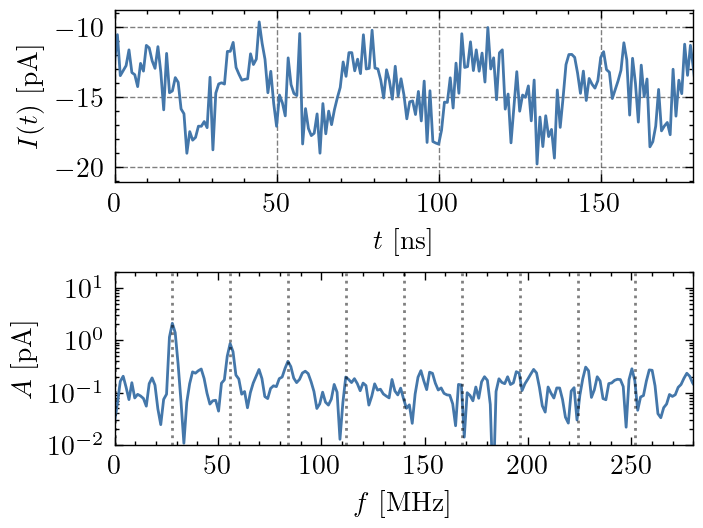

In [349]:
f0          = 1.0
i_at        = 2
max_thd_i   = np.argmax(thd_vals_dis[idx_g[i_at]][f0])
y_val       = data_dis_1600_new[idx_g[i_at]][f0][max_thd_i]
t_val       = np.arange(len(y_val))*DT

fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot(2,1,1)
_       = ax.plot(t_val*1e9, y_val)
_       = ax.set_xlim(0,t_val[SAMPLE_P_PERIOD*5]*1e9)
_       = ax.set_xlabel("$t$ [ns]")
_       = ax.set_ylabel("$I(t)$ [pA]")
ax      = fig.add_subplot(2,1,2)
xf, yf  = get_frequency_spectrum(y_val, DT)
_       = ax.semilogy(xf*1e-6, yf)
_       = ax.set_ylabel('$A$ [pA]')
_       = ax.set_xlim(0,10*F0)
_       = ax.set_ylim(0.01,20)
_       = ax.grid(False)
_       = ax.set_xlabel("$f$ [MHz]")
for n in range(10):
    plt.axvline(n*F0, color='black', ls=':', alpha=0.5)

# fig.savefig("plots/png/example_response.png", transparent=False)
# fig.savefig("plots/pdf/example_response.pdf", transparent=False)
# fig.savefig("plots/svg/example_response.svg", transparent=True)

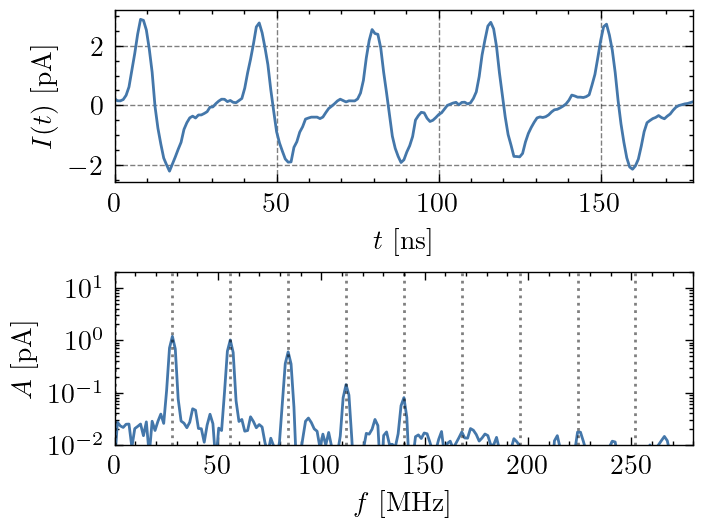

In [326]:
f0          = 28.0
i_at        = 0
max_thd_i   = np.argmax(thd_vals_dis[idx_b[i_at]][f0])
y_val       = data_dis_1600_new[idx_b[i_at]][f0][max_thd_i]
t_val       = np.arange(len(y_val))*DT

fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot(2,1,1)
_       = ax.plot(t_val*1e9, y_val)
_       = ax.set_xlim(0,t_val[SAMPLE_P_PERIOD*5]*1e9)
_       = ax.set_xlabel("$t$ [ns]")
_       = ax.set_ylabel("$I(t)$ [pA]")
ax      = fig.add_subplot(2,1,2)
xf, yf  = get_frequency_spectrum(y_val, DT)
_       = ax.semilogy(xf*1e-6, yf)
_       = ax.set_ylabel('$A$ [pA]')
_       = ax.set_xlim(0,10*F0)
_       = ax.set_ylim(0.01,20)
_       = ax.grid(False)
_       = ax.set_xlabel("$f$ [MHz]")
for n in range(10):
    plt.axvline(n*F0, color='black', ls=':', alpha=0.5)

### Control Voltages

In [76]:
data[9][2]

,E0,E1,E2,E3,E4,E5,E6,E7,G,Eq_Jumps,Jumps,Observable,Error
0,-0.00000,0.03574,-0.04664,0.02297,-0.03243,0.03632,0.00415,0.0,0.0,0.0,155.945000,7.639442e+07,3.813874e+06
1,0.00313,0.03574,-0.04664,0.02297,-0.03243,0.03632,0.00415,0.0,0.0,0.0,155.656667,8.082275e+07,3.881785e+06
2,0.00618,0.03574,-0.04664,0.02297,-0.03243,0.03632,0.00415,0.0,0.0,0.0,156.393333,7.875490e+07,3.910415e+06
3,0.00908,0.03574,-0.04664,0.02297,-0.03243,0.03632,0.00415,0.0,0.0,0.0,156.106667,8.093368e+07,3.863734e+06
4,0.01176,0.03574,-0.04664,0.02297,-0.03243,0.03632,0.00415,0.0,0.0,0.0,158.106667,8.672733e+07,3.683037e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,-0.01176,0.03574,-0.04664,0.02297,-0.03243,0.03632,0.00415,0.0,0.0,0.0,159.915000,6.527377e+07,3.482902e+06
797,-0.00908,0.03574,-0.04664,0.02297,-0.03243,0.03632,0.00415,0.0,0.0,0.0,157.465000,6.831266e+07,3.767870e+06
798,-0.00618,0.03574,-0.04664,0.02297,-0.03243,0.03632,0.00415,0.0,0.0,0.0,156.250000,6.991310e+07,3.623862e+06
799,-0.00313,0.03574,-0.04664,0.02297,-0.03243,0.03632,0.00415,0.0,0.0,0.0,156.198333,6.963296e+07,3.580186e+06


In [5]:
PATH_I = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation/"
pos_store = {}
idx_store = {}
for N_val in [3,9,15]:
   topo        = {"Nx": N_val,"Ny": N_val, "e_pos": [[(N_val-1)//2, 0],[0, 0],[N_val-1, 0],
                  [0, (N_val-1)//2],[N_val-1, (N_val-1)//2],[0, N_val-1],
                  [N_val-1, N_val-1],[(N_val-1)//2, N_val-1]],
               "electrode_type": ['constant']*8}
   sim_class   = Simulation(topo)
   pos         = sim_class.get_positions()
   pos         = {(key+8 if key >= 0 else (abs(key)-1)) : (val) for key, val in pos.items()}
   pos_store[N_val] = pos

   df_I = pd.read_csv(f"{PATH_I}net_currents_Nx={N_val}_Ny={N_val}_Ne=8_0.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:,:]
   df_I = np.sqrt((get_net_currents(df_I)**2).sum())

   idx_store[N_val] = df_I.index

FileNotFoundError: [Errno 2] No such file or directory: '/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation/net_currents_Nx=3_Ny=3_Ne=8_0.csv'

In [ ]:
PATH_I = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation/"
N_val  = 15
arr_C  = np.zeros(shape=(N_SAMPLES,6))
arr_I  = np.zeros(shape=(N_SAMPLES,2*N_val*(N_val-1)+8))

for i in tqdm(range(N_SAMPLES)):
    df_C = data[N_val][i].loc[0,'E1':'E6']
    df_I = pd.read_csv(f"{PATH_I}net_currents_Nx={N_val}_Ny={N_val}_Ne=8_{i}.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:,:]
    df_I = np.sqrt((get_net_currents(df_I)**2).sum())

    arr_C[i,:] = df_C.values
    arr_I[i,:] = df_I.values

    np.save(f"data/{N_val}_arr_I.npy", arr_I)
    np.save(f"data/{N_val}_arr_C.npy", arr_C)

 59%|█████▊    | 357/608 [22:13<15:37,  3.73s/it]


FileNotFoundError: [Errno 2] No such file or directory: '/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation/net_currents_Nx=15_Ny=15_Ne=8_357.csv'

In [3]:
N_val = 9
arr_I = np.load(f"data/{N_val}_arr_I.npy")
arr_C = np.load(f"data/{N_val}_arr_C.npy")

NameError: name 'idx_store' is not defined

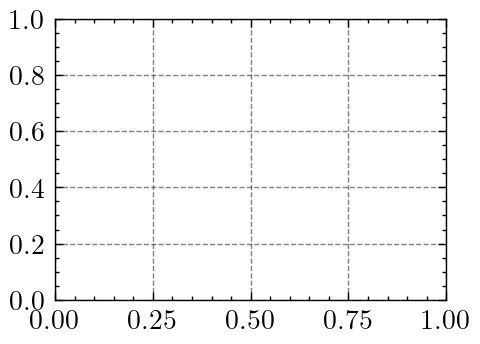

In [4]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
fig.set_figheight(fig.get_figheight()*0.65)

n_s  = [20,10,5]
axes = []
for i, N_val in enumerate([3,9,15]):
    arr_I = np.load(f"data/{N_val}_arr_I.npy")
    arr_C = np.load(f"data/{N_val}_arr_C.npy")
    ax  = fig.add_subplot(1,3,i+1)
    axes.append(ax)
    G   = create_weighted_undirected_graph(pd.Series(np.std(arr_I,axis=0), idx_store[N_val]))
    ax  = display_net_flow_graph(G, pos=pos_store[N_val], log_scale=True, font_size=None, ax=ax, vmin=1e8, vmax=1e10, node_size=n_s[i], cmap=plt.cm.magma)

norm = colors.LogNorm(vmin=1e8, vmax=1e10)
sm = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma)
sm.set_array([])  # required for older Matplotlib versions

fig.colorbar(sm, ax=axes, location="right", pad=0.02, shrink=0.8)

fig.savefig(f"sensitivity_graph.png")

In [426]:
arr1 = np.array([[G.get_edge_data(start*N_val+i+8,start*N_val+i+1+8)['weight'] for i in range(0,N_val//2)]
                 for start in range(0,N_val,N_val//2)])
arr2 = np.array([list(reversed([G.get_edge_data(start*N_val+i+8+N_val//2,start*N_val+i+1+8+N_val//2)['weight'] for i in range(0,N_val//2)]))
                 for start in range(0,N_val,N_val//2)])
arr  = np.vstack([arr1,arr2]).mean(axis=0)

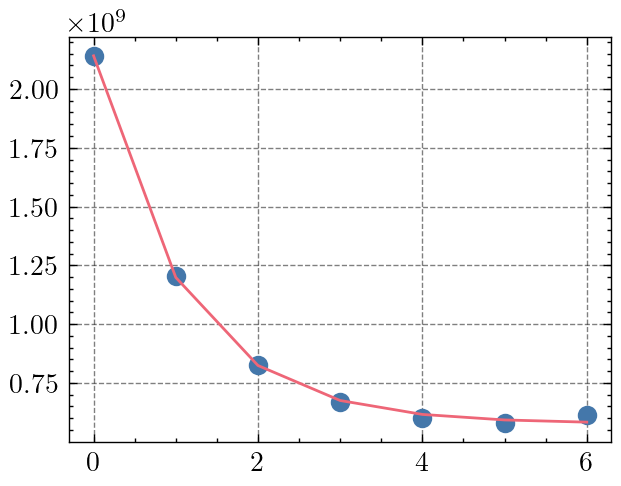

In [445]:
def func(x, a, b, c):
    return a*np.exp(-x/b) + c

x_v = np.arange(len(arr))
y_v = arr.copy()
p,_ = curve_fit(func, x_v, y_v, p0=[1e9,1,1e8])

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
_   = ax.plot(x_v, y_v, 'o')
_   = ax.plot(x_v, func(x_v, *p))

In [438]:
p

array([1.92066101e+09, 3.27448414e+00])

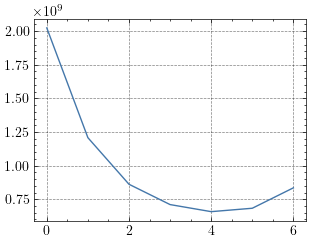

In [422]:
plt.plot(arr1[2,:])

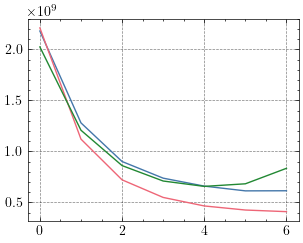

In [416]:
for i in range(3):
    plt.plot(arr[i,:])

In [396]:
[i for i in range(0,N_val,N_val//2)]

[0, 7, 14]

In [399]:
[[(start*N_val+i+8,start*N_val+i+1+8) for i in range(0,N_val//2)] for start in range(0,N_val,N_val//2)]

[[(8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15)],
 [(113, 114),
  (114, 115),
  (115, 116),
  (116, 117),
  (117, 118),
  (118, 119),
  (119, 120)],
 [(218, 219),
  (219, 220),
  (220, 221),
  (221, 222),
  (222, 223),
  (223, 224),
  (224, 225)]]

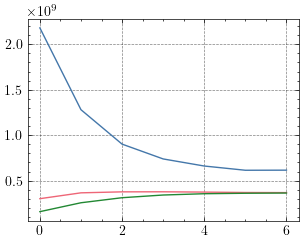

In [400]:
for i in range(3):
    plt.plot(arr[i,:])

In [350]:
G.edges

EdgeView([(0, 15), (15, 14), (15, 16), (15, 30), (1, 8), (8, 9), (8, 23), (2, 22), (22, 21), (22, 37), (3, 113), (113, 98), (113, 114), (113, 128), (4, 127), (127, 112), (127, 126), (127, 142), (5, 218), (218, 203), (218, 219), (6, 232), (232, 217), (232, 231), (7, 225), (225, 210), (225, 224), (225, 226), (9, 10), (9, 24), (23, 24), (23, 38), (10, 11), (10, 25), (24, 25), (24, 39), (11, 12), (11, 26), (25, 26), (25, 40), (12, 13), (12, 27), (26, 27), (26, 41), (13, 14), (13, 28), (27, 28), (27, 42), (14, 29), (28, 29), (28, 43), (29, 30), (29, 44), (16, 17), (16, 31), (30, 31), (30, 45), (17, 18), (17, 32), (31, 32), (31, 46), (18, 19), (18, 33), (32, 33), (32, 47), (19, 20), (19, 34), (33, 34), (33, 48), (20, 21), (20, 35), (34, 35), (34, 49), (21, 36), (35, 36), (35, 50), (36, 37), (36, 51), (37, 52), (38, 39), (38, 53), (39, 40), (39, 54), (40, 41), (40, 55), (41, 42), (41, 56), (42, 43), (42, 57), (43, 44), (43, 58), (44, 45), (44, 59), (45, 46), (45, 60), (46, 47), (46, 61), (47,

In [335]:
vals = []
for i, N_val in enumerate([3,9,15]):
    arr_I = np.load(f"data/{N_val}_arr_I.npy")
    vals.append(np.sum(np.std(arr_I,axis=0)))

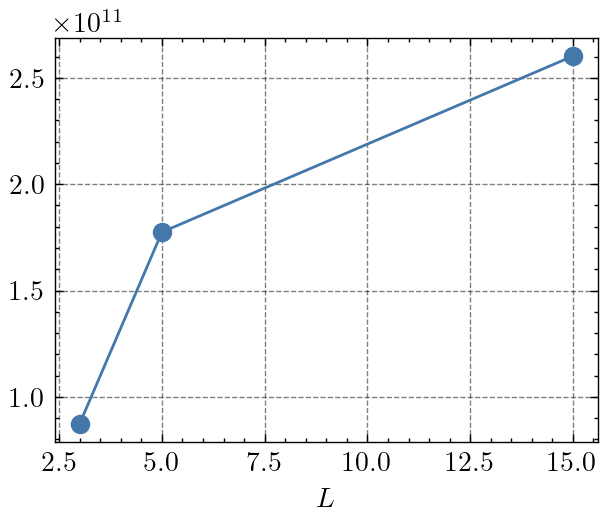

In [343]:
fig, ax = plt.subplots(dpi=200)
_       = ax.plot([3,5,15], vals,'o-')
_       = ax.set_xlabel("$L$")
_       = ax.set_ylabel("")

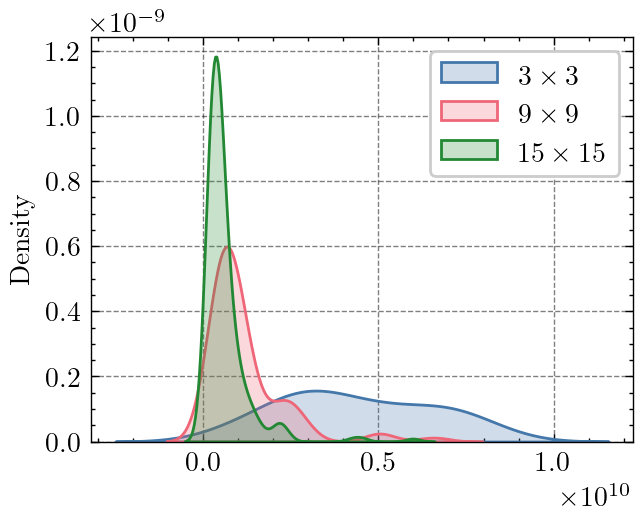

In [ ]:
fig, ax = plt.subplots(dpi=200)
for N in [3,9,15]:
    arr_I   = np.load(f"data/{N}_arr_I.npy")
    arr_C   = np.load(f"data/{N}_arr_C.npy")
    ax      = sns.kdeplot(np.std(arr_I,axis=0)/np.mean(arr_I,axis=0), ax=ax, fill=True, label=f"${N} \\times {N}$")
ax.legend()
fig.savefig("test.png")

---

In [34]:
ctrl_volt = {N : np.array([data[N][i].loc[0,"E1":"E6"].round(6).values for i in range(N_SAMPLES)])}

In [4]:
R_VALUES    = [50.0,100.0,200.0,400.0,800.0,1600.0]
N_SAMPLES_R = 608
data_R_15   = {R : {i : pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_{R}_15.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES_R)} for R in R_VALUES}
data_R_10   = {R : {i : pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_{R}_10.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES_R)} for R in R_VALUES}
data_R_19   = {R : {i : pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_{R}_19.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES_R)} for R in R_VALUES}

In [5]:
N_SAMPLES   = 608
data_3      = {i : pd.read_csv(f"{PATH}Nx=3_Ny=3_Ne=8_{i}.csv") for i in range(N_SAMPLES)}
data_9      = {i : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{i}.csv") for i in range(N_SAMPLES)}
data_new_3  = [data_3[i].iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES)]
data_new_9  = [data_9[i].iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES)]

In [6]:
dim             = 2
n_vals          = np.arange(1,dim+1,1)
hh_vector_3     = np.array([hh_amplitudes(data_new_3[i], n_vals) for i in range(N_SAMPLES)])
hh_vector_9     = np.array([hh_amplitudes(data_new_9[i], n_vals) for i in range(N_SAMPLES)])

### Convex Hull

45.90216780360559
93.94471801328905


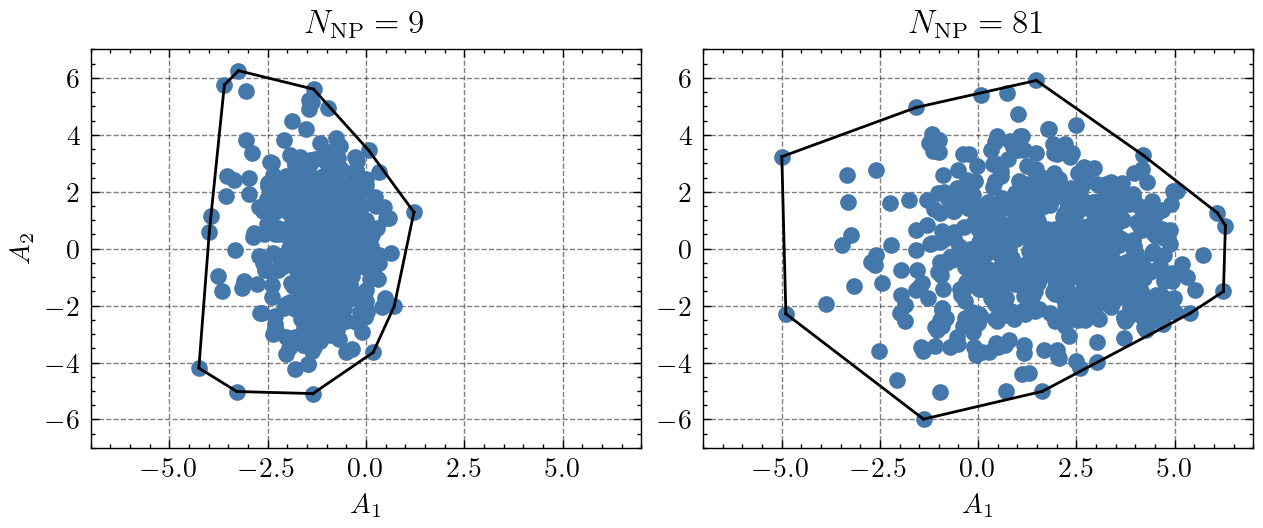

In [8]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

hull    = ConvexHull(hh_vector_3)
V_hull  = hull.volume
print(V_hull)
ax1.plot(hh_vector_3[:,0], hh_vector_3[:,1], 'o', ms=5)
for simplex in hull.simplices:
    ax1.plot(hh_vector_3[simplex, 0], hh_vector_3[simplex, 1], 'k-')
ax1.set_xlim(-7,7)
ax1.set_ylim(-7,7)
# ax1.set_xlim(0,50)
ax1.set_title("$N_\\textrm{NP} = 9$")
ax1.set_xlabel("$A_1$")
ax1.set_ylabel("$A_2$")

hull    = ConvexHull(hh_vector_9)
V_hull  = hull.volume
print(V_hull)
ax2.plot(hh_vector_9[:,0], hh_vector_9[:,1], 'o', ms=5)
for simplex in hull.simplices:
    ax2.plot(hh_vector_9[simplex, 0], hh_vector_9[simplex, 1], 'k-')
ax2.set_xlim(-7,7)
ax2.set_ylim(-7,7)
ax2.set_title("$N_\\textrm{NP} = 81$")
ax2.set_xlabel("$A_1$")

fig.savefig("plots/png/enclosed_area_comp.png", transparent=False)
fig.savefig("plots/pdf/enclosed_area_comp.pdf", transparent=False)
fig.savefig("plots/svg/enclosed_area_comp.svg", transparent=True)